In [1]:
import gym
from gym import spaces
from rljax.algorithm import DQN
from rljax.trainer import Trainer
import numpy as np
import pandas as pd

from environment import Env

In [2]:
data = pd.read_csv("SH_SDS_data_4.csv", index_col=0)
data.current_state = [('000'+str(cs))[-3:] for cs in data.current_state]
prob = pd.read_csv("SH_SDS_transition_matrix.csv", index_col=0)
prob.index = [('000'+str(idx))[-3:] for idx in prob.index]

In [3]:
def base_reward(action, last_state, current_state):
    return 100 if action > 100 else action

In [4]:
NUM_AGENT_STEPS = 5000
SEED = 0

env = Env(data, prob, base_reward, [1000, -500], 1000)
env_test = Env(data, prob, base_reward, [1000, -500], 1000)

algo = DQN(
    num_agent_steps=NUM_AGENT_STEPS,
    state_space=env.state_space,
    action_space=env.action_space,
    seed=SEED,
    batch_size=256,
    start_steps=1000,
    update_interval=1,
    update_interval_target=400,
    eps_decay_steps=0,
    loss_type="l2",
    lr=1e-3,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    log_dir="",
    num_agent_steps=NUM_AGENT_STEPS,
    eval_interval=1000,
    seed=SEED,
)
trainer.train()

Num steps: 1000     Return: 163.2   Time: 0:00:21
Num steps: 2000     Return: -20679.9   Time: 0:00:44
Num steps: 3000     Return: -282.2   Time: 0:01:08
Num steps: 4000     Return: -168.7   Time: 0:01:32
Num steps: 5000     Return: -292.6   Time: 0:01:55


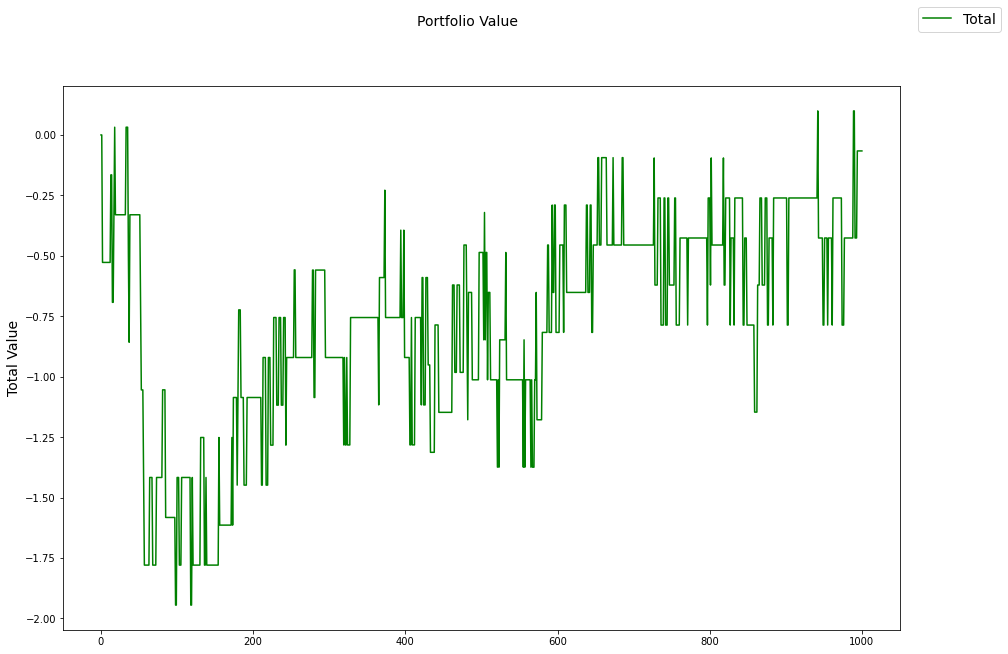

In [5]:
env.plot()

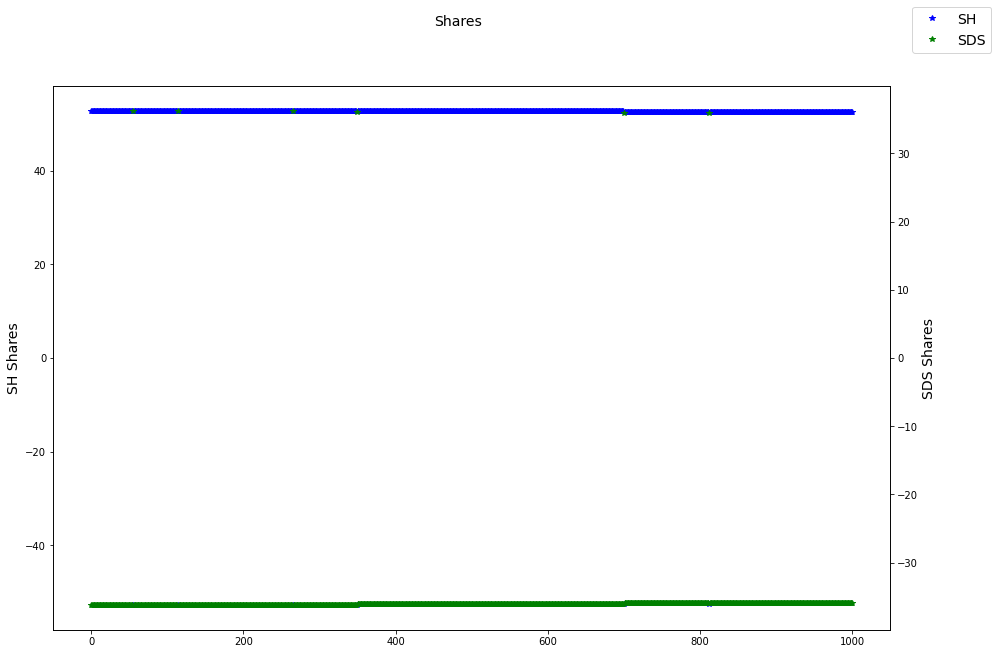

In [6]:
env.plot('share_history')